In [2]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac/')


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
plt.rcParams['figure.titlesize'] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
matplotlib.rcParams["axes.titlesize"] = 6

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import zarr
from glob import glob
import pandas as pd
import seaborn as sns
from matplotlib import cm

from skimage.measure import regionprops_table, label
import matplotlib
import scienceplots


In [3]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac/')


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
from statannotations.Annotator import Annotator
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')
from numba import njit
matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True

resize_amount = 1
pix_mic_conv = 0.065 / 17


all_data = pd.read_pickle("../../single_cell_projection_diffraction/all_data.pickle")

wavelength_colours = ["k", "b", "g", "orange", "r"] 

standard_cell = all_data.query("`True Width` == 1.04")
max_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].max()
min_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].min()
mid_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].unique()[1]

correction_cell = standard_cell.query("`Imaging Modality` == 'membrane' & `Wavelength` == 0 & `Depth of Focus` == @max_dof_membrane").iloc[0]

max_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].max()
min_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].min()
mid_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].unique()[1]
high_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @min_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
mid_dof_wavelength_FL= standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @mid_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()

high_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @min_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
mid_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @mid_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()


high_low_dof = pd.concat([high_dof_wavelength_FL, low_dof_wavelength_FL, high_dof_wavelength_membrane, low_dof_wavelength_membrane, mid_dof_wavelength_membrane, mid_dof_wavelength_FL])
imshow_data = all_data.loc[high_low_dof.index]

profiles = []
for index, row in imshow_data.iterrows():
    profiles.append(row["profile"])

max_int = np.max(profiles)
#profiles[0] = profiles[0]/profiles[0].max() * max_int

profiles = [x/x.max() * max_int for x in profiles]

x_axes = []
for plot_profile in profiles:
    x_axis = np.arange(0,len(plot_profile),1).astype(float)
    x_axis -= x_axis.max()/2
    x_axis *= pix_mic_conv
    x_axes.append(x_axis)

imshow_data["profile"] = profiles
imshow_data["x axis"] = x_axes
imshow_data = imshow_data.explode(["profile", "x axis"])

def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):


    membrane_thickness = 0.05 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

additional_width = 0
raster_additional_width = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

def calculate_fwhm(y):
    x = np.arange(len(y))
    peak_index = np.argmax(y)
    half_max = y[peak_index] / 2

    # Find index where y first drops below half_max on the left side of the peak
    left_idx = np.where(y[:peak_index] < half_max)[0]
    if left_idx.size > 0:
        left_idx = left_idx[-1]
        # Linear interpolation for more accuracy
        if left_idx + 1 < len(y):
            left_interp = interp1d(y[left_idx:left_idx + 2], x[left_idx:left_idx + 2])
            left_interpolated = left_interp(half_max)
        else:
            left_interpolated = x[left_idx]
    else:
        left_interpolated = x[0]

    # Find index where y first drops below half_max on the right side of the peak
    right_idx = np.where(y[peak_index:] < half_max)[0]
    if right_idx.size > 0:
        right_idx = right_idx[0] + peak_index
        # Linear interpolation for more accuracy
        if right_idx > 0:
            right_interp = interp1d(y[right_idx - 1:right_idx + 1], x[right_idx - 1:right_idx + 1])
            right_interpolated = right_interp(half_max)
        else:
            right_interpolated = x[right_idx]
    else:
        right_interpolated = x[-1]

    # Calculate FWHM
    fwhm = right_interpolated - left_interpolated
    return fwhm*pix_mic_conv

In [5]:
human_regionprops_dirs = glob("../../human_annotation_quality/*/masks/masks.zarr")
gt_dirs = sorted(glob("../../human_annotation_quality/projection_analysis_cw//training_data/*_masks*"))


In [6]:
gt_cell = raster_cell_3d(3/pix_mic_conv, 1.019999/pix_mic_conv, 0)
gt_cell = np.pad(gt_cell.sum(axis=0), 50)


In [7]:
a_cell = tifffile.imread('../../single_cell_projection_diffraction/targeted_simulation_output_cyto/1.0199999999999998_iPSF_ePSF_green.tiff')

In [8]:
a_cell = tifffile.imread('../../single_cell_projection_diffraction/targeted_simulation_output/1.0199999999999998_iPSF_ePSF_green.tiff')

In [9]:
a_cell.shape

(234, 792, 336)

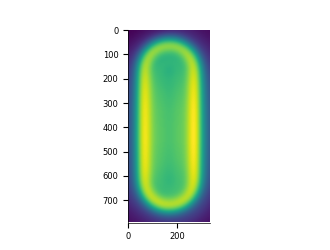

In [10]:
plt.imshow(a_cell.sum(axis=0))

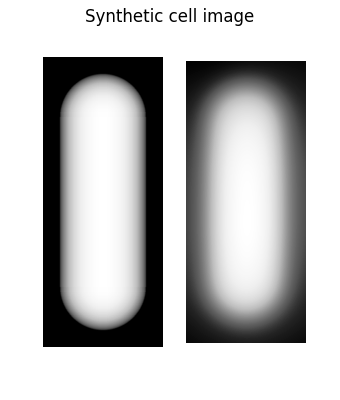

In [11]:
cyto_image = tifffile.imread("../../single_cell_projection_diffraction/targeted_simulation_output_cyto/1.0199999999999998_iPSF_ePSF_darkred.tiff")
fig, axs = plt.subplots(1,2, figsize=(1.7,2), dpi = 200)
axs[0].imshow(gt_cell, cmap="Greys_r")
axs[0].axis("off")
axs[1].imshow(cyto_image.sum(axis=0), cmap="Greys_r")
plt.axis("off")
plt.suptitle("Synthetic cell image",fontsize=6)
plt.savefig("a.svg")

In [12]:
melted_data = pd.read_pickle("../../single_cell_projection_diffraction/membrane_targeted_simulation_data_cyto.pickle")

In [13]:
pix_mic_conv = 0.065 / 15
resize_amount = 1
sim_width = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.7 & `PSF Type` == 'ePSF'")["True Width"].iloc[0]
a_cell = np.pad(raster_cell_3d(3/pix_mic_conv, sim_width/pix_mic_conv, 0), ((0,0), (50, 50), (50,50)))
unconv_profile = a_cell.sum(axis=0)[a_cell.shape[1]//2]
unconv_profile = unconv_profile/unconv_profile.max()

In [14]:
plot_profile_red = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.7 & `PSF Type` == 'ePSF'")["Profile"].iloc[0]
plot_profile_red = plot_profile_red/plot_profile_red.max()

plot_profile_green = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.5 & `PSF Type` == 'ePSF'")["Profile"].iloc[0]
plot_profile_green = plot_profile_green/plot_profile_green.max()

plot_profile_green_tPSF = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.5 & `PSF Type` == 'tPSF'")["Profile"].iloc[0]
plot_profile_green_tPSF = plot_profile_green_tPSF/plot_profile_green_tPSF.max()

plot_profile_red_tPSF = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.7 & `PSF Type` == 'tPSF'")["Profile"].iloc[0]
plot_profile_red_tPSF = plot_profile_red_tPSF/plot_profile_red_tPSF.max()

In [15]:
red_FWHM = calculate_fwhm(plot_profile_red)/2
green_FWHM_tPSF = calculate_fwhm(plot_profile_green_tPSF)/2
green_FWHM = calculate_fwhm(plot_profile_green)/2

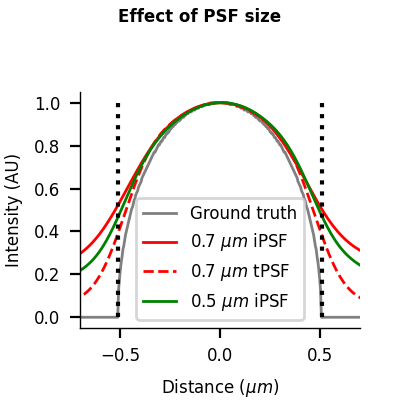

In [16]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)
plt.xlabel("Distance ($\mu m$)")
plt.ylabel("Intensity (AU)")
plt.subplots_adjust(left=0.2, top = 0.77, bottom=0.18, right = 0.9)
x_axis = np.arange(-len(unconv_profile)/2,len(unconv_profile)/2) * pix_mic_conv 
tPSF_x_axis = np.arange(-len(plot_profile_green_tPSF)/2,len(plot_profile_green_tPSF)/2) * pix_mic_conv
plt.plot(x_axis,unconv_profile, c = "grey", label = "Ground truth")
plt.plot(x_axis- 0.0125,plot_profile_red, c = "red", label = "0.7 $\mu m$ iPSF")
plt.plot(tPSF_x_axis,plot_profile_red_tPSF, c = "red", linestyle = "--", label = "0.7 $\mu m$ tPSF")

plt.plot(x_axis- 0.0125 ,plot_profile_green, c = "green", label = "0.5 $\mu m$ iPSF")



left_border = np.nonzero(unconv_profile)[0][0]
right_border = np.nonzero(unconv_profile)[0][-1]
plt.plot([-sim_width/2, -sim_width/2],[0,1], c = "k", linestyle = ":", linewidth=1.5)
plt.plot([sim_width/2, sim_width/2],[0,1], c = "k", linestyle = ":", linewidth=1.5)
plt.xlim(-0.7,0.7)
plt.suptitle("Effect of PSF size", fontsize=6, weight = "bold")
plt.legend()
plt.savefig("b.svg")

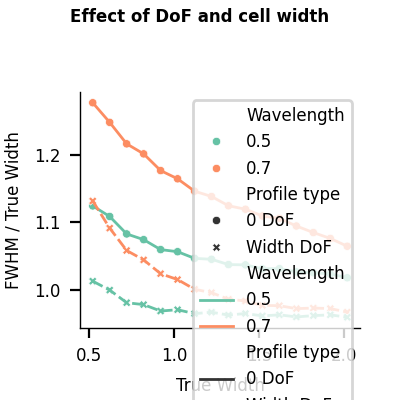

In [17]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)
sns.scatterplot(melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1"), x = "True Width", y = "Observed Width / True Width", hue = "Wavelength", style="Profile type", palette="Set2")
sns.lineplot(melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1"), x = "True Width", y = "Observed Width / True Width", hue = "Wavelength", style="Profile type", palette="Set2")
plt.subplots_adjust(left=0.2, top = 0.77, bottom=0.18, right = 0.9)
plt.ylabel("FWHM / True Width")
plt.suptitle("Effect of DoF and cell width", fontsize=6, weight = "bold")
plt.savefig("c.svg")

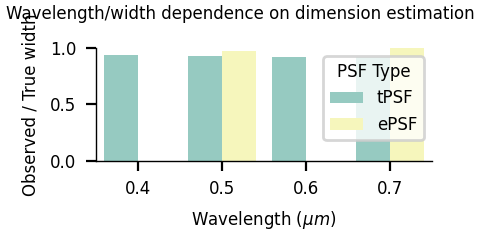

In [18]:
fig, ax = plt.subplots(1,1, figsize=(2.4,1.2), dpi = 200)
sns.barplot(data = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF'"), x = "Wavelength", y = "Observed Width / True Width", hue = "PSF Type", palette="Set3")
plt.subplots_adjust(top = 0.8, left=0.2, bottom=0.33, right = 0.9)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Observed / True width")
plt.ylim(0,1)
plt.suptitle("Wavelength/width dependence on dimension estimation", fontsize=6)
plt.savefig("e.svg")

In [19]:
human_regionprops = []
for human_regionprops_dir in human_regionprops_dirs:
    imgs = zarr.open(human_regionprops_dir)
    for i, gt_dir in enumerate(gt_dirs):
        projection, wavelength, _, _ = gt_dir.split("/")[-1].split("_")
        wavelength = float(wavelength)
        properties = pd.DataFrame(regionprops_table(label(imgs[i]) , properties = ["area", "minor_axis_length"])) * 0.065
        properties["Projection"] = projection
        properties["Wavelength"] = wavelength
        human_regionprops.append(properties)
human_regionprops = pd.concat(human_regionprops)
human_regionprops["Mask"] = "Human"

gt_regionprops = []
for gt_dir in gt_dirs:
    projection, wavelength, _, _ = gt_dir.split("/")[-1].split("_")
    wavelength = float(wavelength)
    properties = pd.DataFrame(regionprops_table(label(np.array(Image.open(gt_dir))), properties = ["area", "minor_axis_length"]))/3 * 0.065
    properties["Projection"] = projection
    properties["Wavelength"] = wavelength
    gt_regionprops.append(properties)
gt_regionprops = pd.concat(gt_regionprops)
gt_regionprops["Mask"] = "Ground truth"

In [20]:
all_regionprops = pd.concat([gt_regionprops, human_regionprops])
all_regionprops["Projection/Wavelength"] = "Proj " +all_regionprops["Projection"] + "\n" + all_regionprops["Wavelength"].astype(str)+ "um"

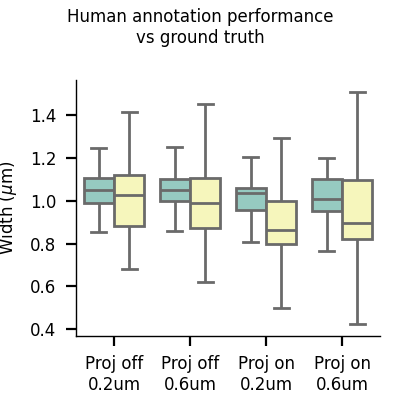

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your data import code here
# ...

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)
sns.boxplot(data=all_regionprops, y="minor_axis_length", x="Projection/Wavelength", hue="Mask", showfliers=False, ax=ax, palette="Set3")
plt.xlabel("")
plt.ylabel("Width ($\mu$m)")
fig.subplots_adjust(left=0.19, bottom=0.16, right=0.95, top=0.8)
plt.suptitle("Human annotation performance\nvs ground truth", fontsize=6)

# Remove the legend
ax.legend_.remove()

# Save or show the plot without the legend
plt.savefig("a.svg")
plt.show()


/tmp/ipykernel_3805/2181884358.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  legend_fig.show()


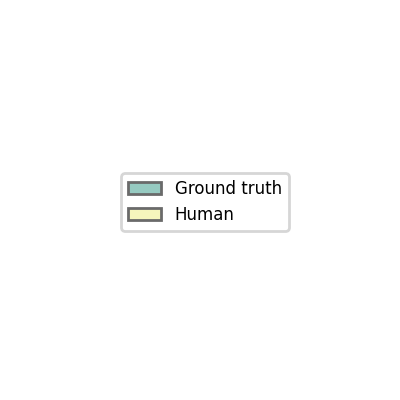

In [22]:
# Capture the legend handles and labels from original plot
handles, labels = ax.get_legend_handles_labels()

# Create a new figure for the legend
legend_fig = plt.figure(figsize=(2, 2), dpi=200)

# Create a subplot, but make it invisible by setting frame_on to False
legend_ax = legend_fig.add_subplot(111, frame_on=False)

# Make everything in the subplot invisible, including axes
legend_ax.axis('off')

# Create the legend using the handles and labels captured earlier
legend_ax.legend(handles, labels, loc='center')

# Save or show the legend figure
# legend_fig.savefig("legend.png")
plt.savefig("a_legend.svg")
legend_fig.show()


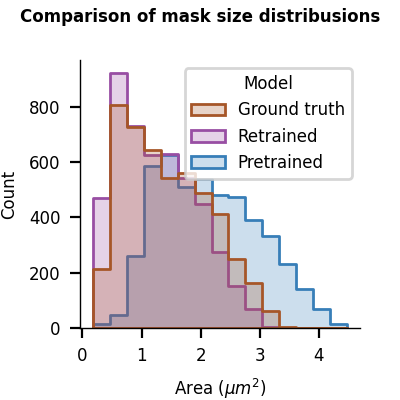

In [23]:
temp_cmap = [sns.color_palette("Set1")[6], sns.color_palette("Set1")[3], sns.color_palette("Set1")[1]]
area_dist_data = pd.read_pickle("../../Omnipose_pretrained_vs_retrained/omnipose_size_data.pickle")
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=200)
area_dist_data.loc[area_dist_data['Model'] == "Syntrained", 'Model'] = "Retrained"
sns.histplot(data = area_dist_data, hue = "Model", x = "area", ax = ax, palette=temp_cmap, element = "step", bins = 15,)
plt.xlabel("Area ($\mu m^2$)")
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 0.9)
plt.suptitle("Comparison of mask size distribusions", fontsize=6, weight = "bold")
plt.savefig("c.svg")

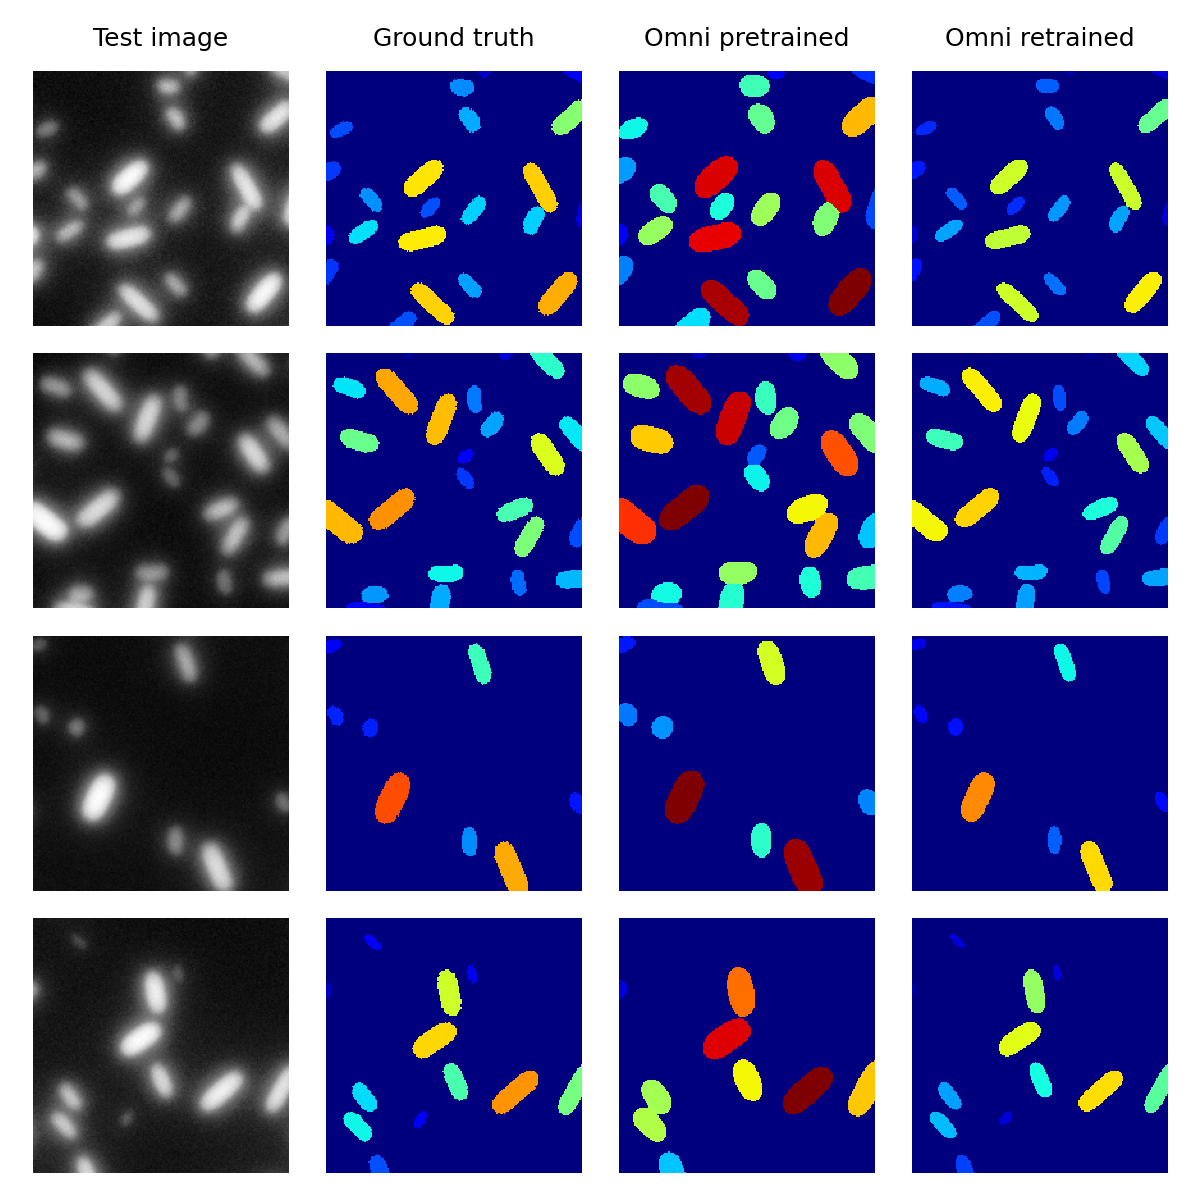

In [24]:
def create_size_mask(masks):
    size_masks = np.zeros_like(masks).astype(np.int64)
    for label in np.unique(masks)[1:]:
        bin_mask = (masks == label)
        mask_size = np.sum(bin_mask)
        size_masks += (bin_mask*mask_size)
    return size_masks

fig, axs = plt.subplots(4, 4, figsize=(4,4), dpi = 300)
for i in range(4):
    cells = np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/test_data/000{str(i*3)}.png"))[400:600,400:600]
    masks_syntrained = create_size_mask(np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/segmented_test_images/syntrained_{str(i*3)}.png"))[400:600,400:600])
    masks_pretrained = create_size_mask(np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/segmented_test_images/pretrained_{str(i*3)}.png"))[400:600,400:600])
    GT = create_size_mask(np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/test_data/000{str(i*3)}_masks.png"))[400:600,400:600])

    
    vmin = np.min(np.concatenate([GT, masks_syntrained, masks_pretrained]))
    vmax = np.max(np.concatenate([GT, masks_syntrained, masks_pretrained]))



    axs[i,0].imshow(cells, cmap="Greys_r")
    axs[i,1].imshow(GT, vmin=vmin, vmax=vmax, cmap="jet", interpolation="none")
    axs[i,3].imshow(masks_syntrained, vmin=vmin, vmax=vmax, cmap="jet",interpolation="none")
    axs[i,2].imshow(masks_pretrained, vmin=vmin, vmax=vmax, cmap="jet",interpolation="none")

axs[0,0].set_title("Test image")
axs[0,1].set_title("Ground truth")
axs[0,3].set_title("Omni retrained")
axs[0,2].set_title("Omni pretrained")
for ax in axs.flatten():
    ax.set_axis_off()
plt.savefig("imgs.svg")
plt.tight_layout()

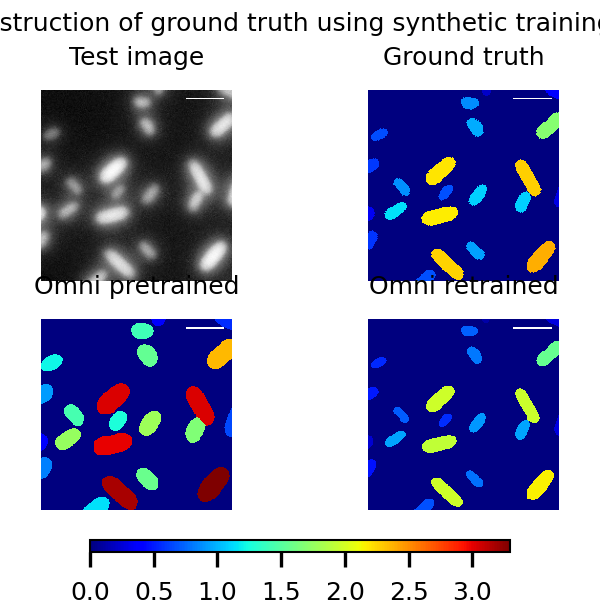

In [25]:
def create_size_mask(masks):
    size_masks = np.zeros_like(masks).astype(float)
    for label in np.unique(masks)[1:]:
        bin_mask = (masks == label)
        mask_size = np.sum(bin_mask)
        size_masks += (bin_mask*mask_size) * (0.065**2)
    return size_masks

fig, axs = plt.subplots(2, 2, figsize=(2,2), dpi = 300)
for i in range(1):
    cells = np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/test_data/000{str(i*3)}.png"))[400:600,400:600]
    masks_syntrained = create_size_mask(np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/segmented_test_images/syntrained_{str(i*3)}.png"))[400:600,400:600])
    masks_pretrained = create_size_mask(np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/segmented_test_images/pretrained_{str(i*3)}.png"))[400:600,400:600])
    GT = create_size_mask(np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/test_data/000{str(i*3)}_masks.png"))[400:600,400:600])

    
    vmin = np.min(np.concatenate([GT, masks_syntrained, masks_pretrained]))
    vmax = np.max(np.concatenate([GT, masks_syntrained, masks_pretrained]))



    axs.flatten()[0].imshow(cells, cmap="Greys_r")
    axs.flatten()[1].imshow(GT, vmin=vmin, vmax=vmax, cmap="jet", interpolation="none")
    axs.flatten()[3].imshow(masks_syntrained, vmin=vmin, vmax=vmax, cmap="jet",interpolation="none")
    axs.flatten()[2].imshow(masks_pretrained, vmin=vmin, vmax=vmax, cmap="jet",interpolation="none")

    for _ in range(4):
        scalebar = ScaleBar(0.05, "um", length_fraction=0.5, scale_loc="none", box_alpha=0, color="white", box_color="k") # 2 micon
        axs.flatten()[_].add_artist(scalebar)
mappable = axs.flatten()[1].imshow(GT, vmin=vmin, vmax=vmax, cmap="jet", interpolation="none")

axs.flatten()[0].set_title("Test image")
axs.flatten()[1].set_title("Ground truth")
axs.flatten()[3].set_title("Omni retrained")
axs.flatten()[2].set_title("Omni pretrained")


for ax in axs.flatten():
    ax.set_axis_off()

fig.subplots_adjust(bottom=0.2)

# Create the colorbar using the vmin and vmax
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cb = plt.colorbar(mappable, cax=cbar_ax, orientation='horizontal', ticks=np.linspace(0,3.5,8))
cb.set_label('Cell size (pixels)')
plt.suptitle("Reconstruction of ground truth using synthetic training data")
fig.subplots_adjust(left=0.0, bottom=0.15, right=1, top=0.85)
plt.savefig("d.svg")
plt.show()




In [26]:
cell_masks = np.array(Image.open(f"../single_cell_projection_diffraction/scattered_cells_for_figure_ePSF_darkred/4_masks.png"))
cell_masks_segmented = np.array(Image.open(f"../single_cell_projection_diffraction/scattered_cells_for_figure_ePSF_darkred/4_segmented.png"))
cell_image = np.array(Image.open(f"../single_cell_projection_diffraction/scattered_cells_for_figure_ePSF_darkred/4.png"))

In [27]:
import pickle
from scipy.ndimage import binary_dilation
from skimage.transform import rotate
from scipy.signal import find_peaks
with open('../single_cell_projection_diffraction/scattered_cells_for_figure_ePSF_darkred/4.pickle', 'rb') as f:
    mask_info = pickle.load(f) # deserialize using load()

In [28]:
for mask_ID in mask_info.keys():
    a, b = mask_info[mask_ID]["coords_x"]
    c, d = mask_info[mask_ID]["coords_y"]
    a, b, c, d = int(a/3), int(b/3), int(c/3), int(d/3)
    cell_crop = cell_image[a:b,c:d]
    cell_crop = rotate(cell_crop, -mask_info[mask_ID]["angle"], resize = True)
    line_profile = cell_crop[cell_crop.shape[0]//2]
    line_profile = line_profile/line_profile.max()
    mask_peaks = find_peaks(line_profile, height=0.7, distance=(mask_info[2]["width"] / 0.05 / 8))
    if len(mask_peaks[0]) == 1:
        mask_info[mask_ID]["line_profile_width"] = 0
        pass
    else:
        min_height = list(reversed(np.sort(mask_peaks[1]["peak_heights"])))[1]
        mask_peaks = find_peaks(line_profile, height=min_height, distance=(mask_info[2]["width"] / 0.05 / 8))[0]
        assert len(mask_peaks) == 2
        mask_info[mask_ID]["line_profile_width"] = np.diff(mask_peaks)[0] * 0.065
    #mask_peaks = np.array([mask_peaks[0], mask_peaks[-1]])

In [29]:
def create_size_mask_from_profile(masks):
    size_masks = np.zeros_like(masks).astype(float)
    for label in np.unique(masks)[1:]:
        bin_mask = (masks == label)
        measured_width = mask_info[label]["line_profile_width"]
        size_masks += (bin_mask*measured_width)
    return size_masks

In [30]:
def create_width_mask(masks):
    size_masks = np.zeros_like(masks).astype(float)
    mask_IDs = list(mask_info.keys())
    for label in mask_IDs:
        seg_label = np.unique((cell_masks == label) * masks)[1]
        measured_width = mask_info[label]["predicted_width"]
        bin_mask = (masks == seg_label)
        size_masks += (bin_mask*measured_width)
    return size_masks

In [31]:
def create_gt_mask(masks):
    size_masks = np.zeros_like(masks).astype(float)
    mask_IDs = list(mask_info.keys())
    for label in mask_IDs:
        measured_width = mask_info[label]["width"]
        bin_mask = (masks == label)
        size_masks += (bin_mask*measured_width)
    return size_masks

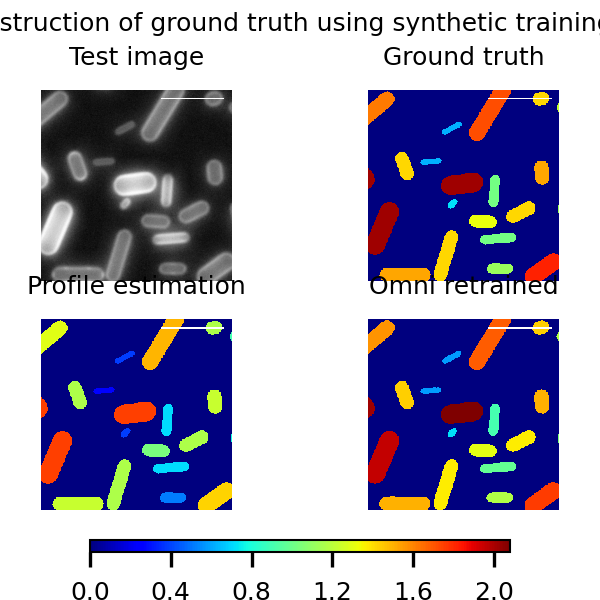

In [32]:
a, b, c, d = 600, 900, 600, 900
fig, axs = plt.subplots(2, 2, figsize=(2,2), dpi = 300)
cells = np.array(Image.open(f"../single_cell_projection_diffraction/scattered_cells_for_figure_ePSF_darkred/4.png"))[a:b,c:d]
masks_syntrained = create_width_mask(np.array(Image.open(f"../single_cell_projection_diffraction/scattered_cells_for_figure_ePSF_darkred/4_segmented.png")))[a:b,c:d]
masks_pretrained = create_size_mask_from_profile(np.array(Image.open(f"../single_cell_projection_diffraction/scattered_cells_for_figure_ePSF_darkred/4_masks.png"))[a:b,c:d])
GT = create_gt_mask(np.array(Image.open(f"../single_cell_projection_diffraction/scattered_cells_for_figure_ePSF_darkred/4_masks.png")))[a:b,c:d]


vmin = np.min(np.concatenate([GT, masks_syntrained, masks_pretrained]))
vmax = np.max(np.concatenate([GT, masks_syntrained, masks_pretrained]))



axs.flatten()[0].imshow(cells, cmap="Greys_r")
axs.flatten()[1].imshow(GT, vmin=vmin, vmax=vmax, cmap="jet", interpolation="none")
axs.flatten()[3].imshow(masks_syntrained, vmin=vmin, vmax=vmax, cmap="jet",interpolation="none")
axs.flatten()[2].imshow(masks_pretrained, vmin=vmin, vmax=vmax, cmap="jet",interpolation="none")

for _ in range(4):
    scalebar = ScaleBar(0.05, "um", length_fraction=0.35, scale_loc="none", box_alpha=0, color="white", box_color="k") # 2 micon
    axs.flatten()[_].add_artist(scalebar)
mappable = axs.flatten()[1].imshow(GT, vmin=vmin, vmax=vmax, cmap="jet", interpolation="none")

axs.flatten()[0].set_title("Test image")
axs.flatten()[1].set_title("Ground truth")
axs.flatten()[3].set_title("Omni retrained")
axs.flatten()[2].set_title("Profile estimation")


for ax in axs.flatten():
    ax.set_axis_off()

fig.subplots_adjust(bottom=0.2)

# Create the colorbar using the vmin and vmax
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cb = plt.colorbar(mappable, cax=cbar_ax, orientation='horizontal', ticks=np.linspace(0, 2.0, 6))
cb.set_label('Cell size (pixels)')
plt.suptitle("Reconstruction of ground truth using synthetic training data")
fig.subplots_adjust(left=0.0, bottom=0.15, right=1, top=0.85)
plt.savefig("b.svg")
plt.show()




In [33]:
np.linspace(0, 2.0, 6)

array([0. , 0.4, 0.8, 1.2, 1.6, 2. ])

In [34]:
cells = np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/test_data/000{str(3)}.png"))[400:600,400:600]
masks_syntrained = create_size_mask(np.array(Image.open(f"../../Omnipose_pretrained_vs_retrained/segmented_test_images/syntrained_{str(3)}.png"))[400:600,400:600])

In [35]:
melted_data = pd.read_pickle("../../single_cell_projection_diffraction/membrane_targeted_simulation_data.pickle")
melted_data["True Width / Observed Width"] = 1/melted_data["Observed Width / True Width"]

DL_segmented = pd.read_pickle("../single_cell_projection_diffraction/membrane_DL_segmented.pickle")
DL_segmented["True Width / Observed Width"] = DL_segmented["True Width"] / DL_segmented["Observed Width"]
DL_segmented["Observed Width / True Width"] = DL_segmented["Observed Width"] / DL_segmented["True Width"]

DL_segmented["PSF Type"] = "ePSF"
DL_segmented.loc[DL_segmented["Colour"] == "green", "Wavelength"] = 0.5
DL_segmented.loc[DL_segmented["Colour"] == "darkred", "Wavelength"] = 0.7
DL_segmented["Profile type"] = "DL"

melted_data = pd.concat([melted_data, DL_segmented])
melted_data.reset_index(inplace=True, drop=True)

In [36]:
melted_data.query("`True Width` < 2.1 & `Profile type` == 'DL' & `Wavelength` == 0.6")

,True Width,PSF Type,Colour,Directory,Observed Width,Observed Width 0 DoF,Wavelength,Profile type,Profile,Observed Width / True Width,True Width / Observed Width


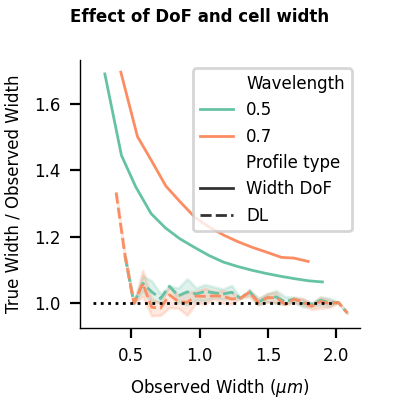

In [37]:
# add units
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)
#sns.scatterplot(melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1"), x = "Observed Width", y = "True Width / Observed Width", hue = "Wavelength", style="Profile type", palette="Set2", legend = False)
data1 = melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1 & `Profile type` == 'Width DoF'")
data2 = melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1 & `Profile type` == 'DL'")
data_plot = pd.concat([data1, data2])
sns.lineplot(data_plot, x = "Observed Width", y = "True Width / Observed Width", hue = "Wavelength", palette="Set2", legend = True, style="Profile type")
#sns.lineplot(melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1 & `Profile type` == 'DL' & `Wavelength` == 0.5"), x = "Observed Width", y = "True Width / Observed Width", hue = "Wavelength",errorbar=("sd",1), palette="Set2", legend = True)

plt.plot([ax.get_xlim()[0],2.],[1,1], c = "k", linestyle = ":")
#ax.fill_betweenx(y=[ax.get_ylim()[0], ax.get_ylim()[1]], x1=0, x2=0.45, color='tab:red', alpha=0.1)
plt.ylabel("True Width / Observed Width")
plt.suptitle("Effect of DoF and cell width", fontsize=6, weight = "bold")
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 0.9)
plt.xlabel("Observed Width ($\mu m$)")
plt.savefig("SI_1.svg")

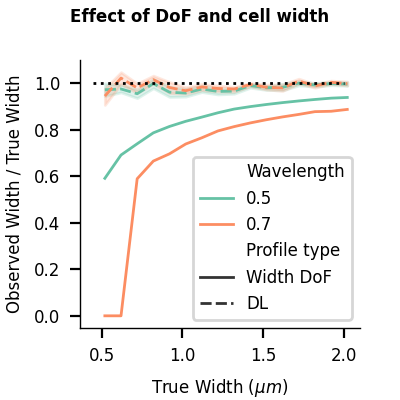

In [38]:
# add units
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)
#sns.scatterplot(melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1"), x = "Observed Width", y = "True Width / Observed Width", hue = "Wavelength", style="Profile type", palette="Set2", legend = False)
data1 = melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1 & `Profile type` == 'Width DoF'")
data2 = melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1 & `Profile type` == 'DL'")
data_plot = pd.concat([data1, data2])
sns.lineplot(data_plot, x = "True Width", y = "Observed Width / True Width", hue = "Wavelength", palette="Set2", legend = True, style="Profile type")
#sns.lineplot(melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1 & `Profile type` == 'DL' & `Wavelength` == 0.5"), x = "Observed Width", y = "True Width / Observed Width", hue = "Wavelength",errorbar=("sd",1), palette="Set2", legend = True)

plt.plot([ax.get_xlim()[0],2.],[1,1], c = "k", linestyle = ":")
#ax.fill_betweenx(y=[ax.get_ylim()[0], ax.get_ylim()[1]], x1=0, x2=0.45, color='tab:red', alpha=0.1)
plt.suptitle("Effect of DoF and cell width", fontsize=6, weight = "bold")
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 0.9)
plt.xlabel("True Width ($\mu m$)")

plt.savefig("f.svg")

In [39]:
melted_data

,True Width,PSF Type,Colour,Directory,Observed Width,Observed Width 0 DoF,Wavelength,Profile type,Profile,Observed Width / True Width,True Width / Observed Width
0,0.52,ePSF,darkred,targeted_simulation_output/0.52_iPSF_ePSF_dark...,0.476667,0.476667,0.7,0 DoF,"[0.4403182326951977, 0.448512601626036, 0.4572...",0.916667,1.090909
1,0.52,ePSF,green,targeted_simulation_output/0.52_iPSF_ePSF_gree...,0.485333,0.485333,0.5,0 DoF,"[0.21252087027961458, 0.21584216715741011, 0.2...",0.933333,1.071429
2,0.52,tPSF,0.4,targeted_simulation_output/0.52_tPSF_0.4.tiff,0.481000,0.481000,0.4,0 DoF,"[0.0036998161700499198, 0.0038524131774555965,...",0.925000,1.081081
3,0.52,tPSF,0.5,targeted_simulation_output/0.52_tPSF_0.5.tiff,0.481000,0.481000,0.5,0 DoF,"[0.004732910832511631, 0.00496628351534466, 0....",0.925000,1.081081
4,0.52,tPSF,0.6,targeted_simulation_output/0.52_tPSF_0.6.tiff,0.489667,0.489667,0.6,0 DoF,"[0.0053977426968003835, 0.00531520010281666, 0...",0.941667,1.061947
...,...,...,...,...,...,...,...,...,...,...,...
1107,1.52,ePSF,darkred,NaN,1.495000,NaN,0.7,DL,NaN,0.983553,1.016722
1108,1.82,ePSF,darkred,NaN,1.755000,NaN,0.7,DL,NaN,0.964286,1.037037
1109,0.52,ePSF,darkred,NaN,0.520000,NaN,0.7,DL,NaN,1.000000,1.000000
1110,0.82,ePSF,darkred,NaN,0.845000,NaN,0.7,DL,NaN,1.030488,0.970414


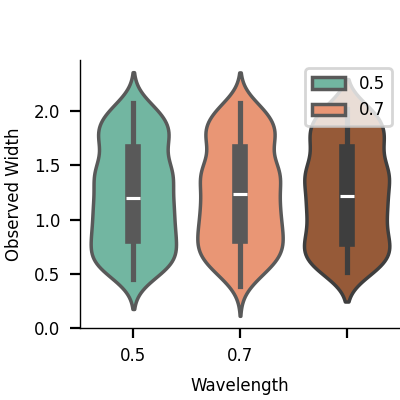

In [40]:
fig, ax1 = plt.subplots(1,1, figsize=(2,2), dpi = 200)
sns.violinplot(data = melted_data.query("`Profile type` == 'DL'"), x = "Wavelength", y = "Observed Width", hue="Wavelength", palette="Set2")
sns.violinplot(data = melted_data.query("`Profile type` == 'DL' & `Wavelength` == 0.7"), y = "True Width", color = sns.color_palette("Set1")[6])

plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 1)
plt.savefig("g.svg")

In [41]:
melted_data.query("`PSF Type` == 'ePSF' & `True Width` < 2.1 & `Profile type` == '0 DoF'")["True Width"].min()

0.52

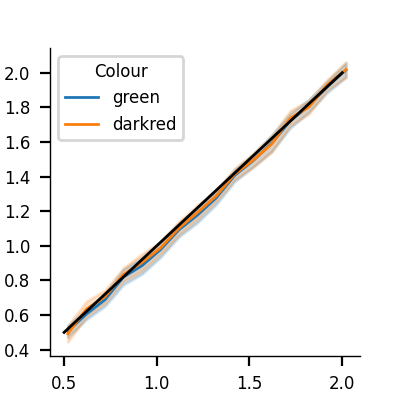

In [42]:

plt.figure(figsize=(2,2), dpi = 200)
sns.lineplot(data = DL_segmented, x = "True Width", y = "Observed Width", hue = "Colour", errorbar=("sd", 1))
plt.plot([0.5,2],[0.5,2], c = "k")

In [43]:
DL_segmented

,True Width,Observed Width,Colour,True Width / Observed Width,Observed Width / True Width,PSF Type,Wavelength,Profile type
0,1.42,1.365,green,1.040293,0.961268,ePSF,0.5,DL
1,1.42,1.365,green,1.040293,0.961268,ePSF,0.5,DL
2,1.32,1.300,green,1.015385,0.984848,ePSF,0.5,DL
3,1.02,0.975,green,1.046154,0.955882,ePSF,0.5,DL
4,0.92,0.910,green,1.010989,0.989130,ePSF,0.5,DL
...,...,...,...,...,...,...,...,...
795,1.52,1.495,darkred,1.016722,0.983553,ePSF,0.7,DL
796,1.82,1.755,darkred,1.037037,0.964286,ePSF,0.7,DL
797,0.52,0.520,darkred,1.000000,1.000000,ePSF,0.7,DL
798,0.82,0.845,darkred,0.970414,1.030488,ePSF,0.7,DL


In [44]:
all_data_omni_symbac_df = pd.read_pickle("../colony_segmentation_comparison/all_data_omni_symbac_df.pickle")

In [45]:
all_data_omni_symbac_df.groupby(['Cell type', 'Model']).mean()

Width
Cell type   Model                   
Alone Cell  Pretrained      1.213929
            SyMBac trained  0.940596
Colony Cell Pretrained      1.003883
            SyMBac trained  0.889085

In [57]:
def remove_outliers(group):
    lower_bound = group['Width'].mean() - 3 * group['Width'].std()
    upper_bound = group['Width'].mean() + 3 * group['Width'].std()
    return group[(group['Width'] >= lower_bound) & (group['Width'] <= upper_bound)]

# Applying the function to each group
filtered_df = all_data_omni_symbac_df.groupby(['Cell type', 'Model']).apply(remove_outliers).reset_index(drop=True)
filtered_df['Cell type'] = filtered_df['Cell type'].replace({'Alone Cell': 'Isolated Cells', 'Colony Cell': 'Clustered Cells'})


In [58]:
temp_cmap = [sns.color_palette("Set1")[1], sns.color_palette("Set1")[3], sns.color_palette("Set1")[1]]


/tmp/ipykernel_3805/1558286097.py:1: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.catplot(x="Cell type", y="Width", hue="Model", kind="violin", data=filtered_df, height=2, palette =temp_cmap, aspect=0.7)


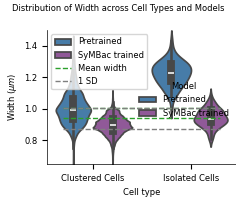

In [60]:
sns.catplot(x="Cell type", y="Width", hue="Model", kind="violin", data=filtered_df, height=2, palette =temp_cmap, aspect=0.7)
plt.suptitle("Distribution of Width across Cell Types and Models")
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 0.9)
plt.ylabel("Width ($\mu m$)")
#plt.ylim(0.5,1.5)
plt.plot([-0.3,1.3],[0.94,0.94], c = "tab:green", linestyle = "--")
plt.plot([-0.3,1.3],[0.94+0.066,0.94+0.066], c = "tab:green", linestyle = "--", label = "Mean width")
plt.plot([-0.3,1.3],[0.94+0.066,0.94+0.066], c = "tab:grey", linestyle = "--")
plt.plot([-0.3,1.3],[0.94-0.066,0.94-0.066], c = "tab:grey", linestyle = "--", label = "1 SD")
plt.legend()
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 1)
plt.ylim(0.65,1.5)

plt.savefig("d.svg")

plt.show()

(0.5, 1.5)

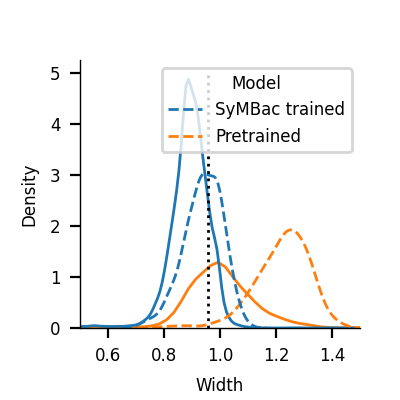

In [994]:
plt.figure(figsize=(2,2), dpi = 200)
sns.kdeplot(data = all_data_omni_symbac_df.query("`Cell type` == 'Colony Cell'"), x = "Width", hue = "Model", common_norm=True)
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 0.9)
sns.kdeplot(data = all_data_omni_symbac_df.query("`Cell type` == 'Alone Cell'"), x = "Width", hue = "Model", common_norm=True, linestyle = "--")
plt.plot([0.957, 0.957],[0,5], c = "k", linestyle = ":")
plt.xlim(0.5,1.5)


(0.5, 1.5)

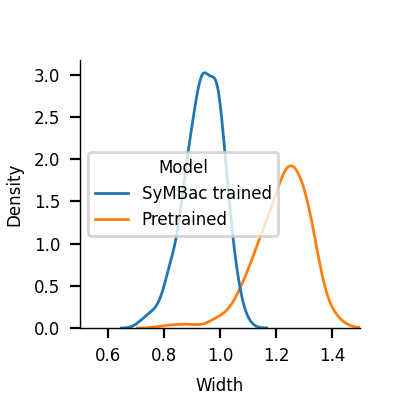

In [900]:
plt.figure(figsize=(2,2), dpi = 200)
sns.kdeplot(data = all_data_omni_symbac_df.query("`Cell type` == 'Alone Cell'"), x = "Width", hue = "Model", common_norm=True)
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 0.9)
plt.xlim(0.5,1.5)

(0.5, 1.5)

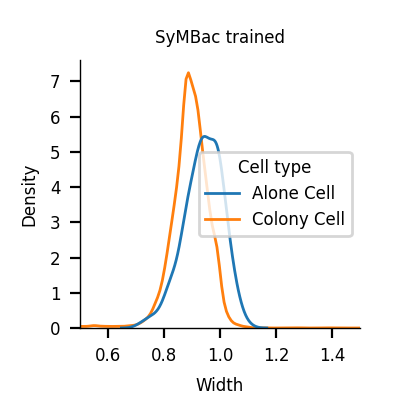

In [907]:
plt.figure(figsize=(2,2), dpi = 200)
sns.kdeplot(data = all_data_omni_symbac_df.query("`Model` == 'SyMBac trained'"), x = "Width", hue = "Cell type", common_norm=False)
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 0.9)
plt.title("SyMBac trained")
plt.xlim(0.5,1.5)

(0.5, 1.5)

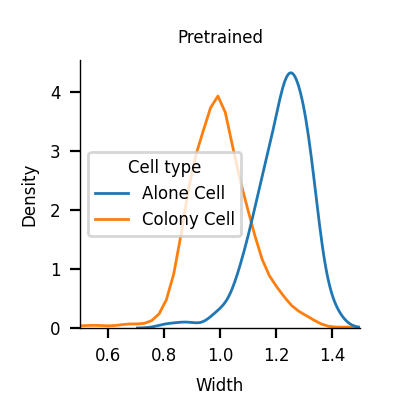

In [906]:
plt.figure(figsize=(2,2), dpi = 200)
sns.kdeplot(data = all_data_omni_symbac_df.query("`Model` == 'Pretrained'"), x = "Width", hue = "Cell type", common_norm=False)
plt.subplots_adjust(left=0.2, top = 0.85, bottom=0.18, right = 0.9)
plt.title("Pretrained")
plt.xlim(0.5,1.5)